# Evaluating Machine Learning models

-  Chapter 4, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)

-  Chapter 5, Section 3 of [Deep Learning Book](https://www.deeplearningbook.org/contents/ml.html)


In the previous notebooks, we have underlined that the goal of a machine learning model is to generalize well on previously unseen examples. Overfitting indeed represents a central issue in the training process. 

Relying on a **validation set** allows us to measure the generalization capability during training, and to take strategic countermeasures to mitigate overfitting. 

**It is of the utmost importance that the test set is not used to make choices about the model and the selection of its hyperparameters**: the examples of the test set must not be used in the validation set. Therefore, we must construct the validation set using examples from training data. 

Let's recap the most common approaches for a fair evaluation of the generalization capability of our model during training.

## Simple hold-out validation 
In the simple hold-out validation we split the training data into two disjoint subsets. 
- The training subset is used to learn the parameters. 
- The validation subset is used to estimate the generalization capability during training: we are allowed to tune the hyperparameters accordingly to the performance on this subset.

A typical split is 80/20: 80 percent of the training data are used for training while the remaining 20 percent are used for validation. 

Since the validation set is used to tune the hyperparameters, we may encounter again a slighter overfitting: the validation set error will underestimate the real generalization error (measured on the test set). 

At the end of the hyperparameter optimization procedure, the performance of our model may be estimated using the test set.



```python
num_validation_samples = len(data)*0.2
np.random.shuffle(data) # Shuffling the data is usually appropriate.

validation_data = data[:num_validation_samples]
data = data[num_validation_samples:]
training_data = data[:]
# Note: labels must be split accordingly

model = get_model()
model.train(training_data)
validation_score = model.evaluate(validation_data)

# At this point you can tune your model,
# retrain it, evaluate it, tune it again...

# Then, finally:
model = get_model()
model.train(np.concatenate([training_data, validation_data]))
test_score = model.evaluate(test_data)
```


## K-fold cross-validation

The **simple hold-out validation approach can be problematic if the resulting validation set is small**: the sampled validation examples may not be representative of the actual distribution of our dataset. Training (and validating) our model on different random splits would results in different values of model performance. In other words, we may observe statistical uncertainty around the estimated average test error.

To address this issue, *k*-fold cross validation is commonly adopted.
The procedure consists in the following steps:
- the dataset is split in *k* non-overlapping subset
- for each subset *i* the model is tested on the *i-th* subset itself and trained on the union of the remaining *k-1* subsets,
- after *k* iteration, we can rely on *k* values of model performance: the final score is obtained averaging the scores across the *k* trials.

Using k-fold cross-validation allows to estimate the average test error using all the examples, at the price of an increased runtime (k training procedures)

![alt text](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)



```python
k = 4
np.random.shuffle(data) # Shuffling the data is usually appropriate.
num_val_samples = len(data) // k
validation_scores = []

for fold in range(k):
    # validation data: data from partition k
    val_data = data[fold * num_val_samples: (fold + 1) * num_val_samples]
    # training data: data from all other partitions
    train_data = np.concatenate([data[:fold * num_val_samples],  data[(fold+ 1) * num_val_samples:]], axis=0)
    # Note: labels must be split accordingly

    # Build the Keras model
    model = get_model() # create a brand new instance of the model at each iteration
    model.train(training_data)
    # Evaluate the model on the validation data
    validation_score = model.evaluate(validation_data)
    validation_scores.append(validation_score)    
    # it is better to delete the model and clear session to free memory
    
# validation score: average of the validation scores of the k folds
validation_score = np.average(validation_scores)
model = get_model()

# train the final model on all non-test data available
model.train(data)
test_score = model.evaluate(test_data)
```

# Model Ensembling

-  Chapter 7, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)

-  Chapter 7, Section 11 of [Deep Learning Book](https://www.deeplearningbook.org/contents/regularization.html)


Ensemble methods consist of **combining the prediction of several different models in order to produce a composite classifier that outperforms the base classifiers**. The idea behind ensembling is that different models will usually make different errors on the test set: pooling together the votes of such models will result in a more accurate final prediction.

The objective is to build several models that are, at the same time:
- as good as possible
- as different as possible

As an example, training the same model with different seeds (different random initializations) will likely result in a homogeneous ensemble and the ensemble improvement over the base classifiers may be small. Modifying the architecture, using different architectures, modify the preprocessing functions or even using different machine learning approaches are preferable solutions.


<img src="https://drive.google.com/uc?id=13l5ajuBgl1Pto6tveOw7jpdXGMyoI44G" alt="Ensemble Picture" height="350" width="500">


How to aggregate the results? The most simple and straightforwards ways to pool the predections of the base classifiers are **average** and **majority voting**
- majority voting selects the class that obtain the highest number of votes
- average voting computes the average of the scores (softmax output) of the base classifiers and select the class with the highest score.


```python
preds_a=model_a.predict(x_val)
preds_b=model_b.predict(x_val)
preds_c=model_c.predict(x_val)
preds_d=model_d.predict(x_val)

final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)
```

Another commonly adopted solution is to do a weighted average of the predictions, where the wheights are obtained according to the performance of base classifiers on the validation set.

Several other aspects need to be addressed when adopting ensemble methods: the number of base classifiers (ensemble size) and the strategies used to introduce *diversity* among base classifiers, to name but a few.

## Classification Evaluation Metrics

Suppose we are tackling a 2 classes classification problem.
Let `y_true` be the true labels of our test samples and `y_pred` be the labels predicted by our classification model.

For the purpose of defining evaluation metrics, we randomly generate `y_true` and `y_pred` vectors for a binary classification problem:


In [2]:
import numpy as np
y_true = np.random.randint(0,2,300)
y_pred = np.random.randint(0,2,300)
unique, counts = np.unique(y_true, return_counts=True)
print('true', y_true[:10],dict(zip(unique, counts)))
unique, counts = np.unique(y_pred, return_counts=True)
print('pred', y_pred[:10],dict(zip(unique, counts)))

true [1 1 1 0 0 1 1 1 1 1] {0: 160, 1: 140}
pred [0 0 1 1 0 1 1 0 0 0] {0: 149, 1: 151}


**[scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)**, a python library for machine learning, offers utilities for metrics evaluation. Let's see the most relevant ones.

In [3]:
from sklearn import metrics

In [4]:
# confusion matrix: 
#     on each row: true class
#     on each column: predicted class
metrics.confusion_matrix(y_true,y_pred)

array([[80, 80],
       [69, 71]])

Confusion matrix cells can be immediately mapped to the cells of this table:

![confusion matrix](https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png)


In [5]:
# accuracy: (TP+TN)/(TP+FP+FN+TN): percentage of correctly predicted samples
metrics.accuracy_score(y_true,y_pred)

0.5033333333333333

In [6]:
# precision: TP/(TP+FP): The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
metrics.precision_score(y_true,y_pred)

0.47019867549668876

In [7]:
# recall: TP/(TP+FN): The recall is intuitively the ability of the classifier to find all the positive samples.
metrics.recall_score(y_true,y_pred)

0.5071428571428571

In [ ]:
# f1-score: 2*(precision*recall)/(precision + recall). The F1-score is the harmonic mean of precision and sensitivity
metrics.f1_score(y_true,y_pred)

0.5419354838709678

In [ ]:
# classification report: Build a text report showing the main classification metrics
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       150
           1       0.53      0.56      0.54       150

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.53       300
weighted avg       0.53      0.53      0.53       300



If we resort to the probability score of our classification model, we can evaluate the ROC curve.

In [ ]:
y_score = np.random.rand(300)
np.min(y_score),np.max(y_score)

(0.0012190831201817076, 0.9910220578630067)

In [ ]:
fpr,tpr,th = metrics.roc_curve(y_true,y_score)
# Sensitivty = TPR(True Positive Rate)= Recall = TP/(TP+FN)
# (1 - Specificity) = FPR(False Positive Rate)= FP/(TN+FP)

roc_auc = metrics.roc_auc_score(y_true,y_score)

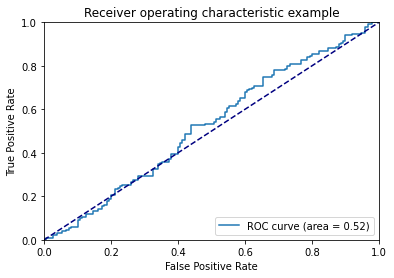

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## An overview of Siamese Neural Networks

The first intuition of siamese architecture has been presented in this contribution:


`
[1] BROMLEY, Jane, et al. Signature verification using a" siamese" time delay neural network. In: Advances in neural information processing systems. 1994. p. 737-744
`

A **siamese neural network** consists of two identical sub-networks joined at their outputs. During training the two sub-networks extract features from
two inputs, while the joining neuron measures the distance between the two feature vectors. 


![siamese](https://d3i71xaburhd42.cloudfront.net/1029bb5c9f9cb7ab486eb0c2a2a1c59104820928/3-Figure3-1.png)

In [1], *verification* consists of comparing an extracted feature vector  with a stored feature vector for the signer. Signatures closer to this stored representation than a chosen threshold are accepted, all other signatures are rejected as forgeries. 

More recently, the *siamese approach* has been proposed to tackle the **few-shot learning** task in this contribution:

`[2] Koch, Gregory, Richard Zemel, and Ruslan Salakhutdinov. "Siamese neural networks for one-shot image recognition." ICML deep learning workshop. Vol. 2. 2015.`

In the *one-shot learning setting* we must correctly make predictions given only a single example of each new class.

Siamese architecture aims to naturally rank similarity between inputs. 
Once a network has been tuned, we can then capitalize on powerful discriminative features to generalize the predictive power of the network not just to new data, but to entirely new classes from unknown distributions. 

In other words, the idea is to exploit "past" experience to learn a good metric for choosing the nearest neighbors: networks are trained to map data into a representation space where points of the same class are nearby.

![alt text](https://lijiancheng0614.github.io/2017/05/21/2017_05_21_Meta-Learner_LSTM/fig1.png)

**Back to our project goal**: we are not in the few shot learning setting. 

However, 
- can we rely on siamese architecture for a sort of **model calibration** based on normal tissue patch??!? 
- if so, how to combine learnt representations? Is it better to compute the distance of the representations or simply concatenate them?
